# Pipeline + forecast

In [42]:

import numpy as np
import pandas as pd
print(f"Using pandas {pd.__version__}")
import matplotlib.pyplot as plt

import pmdarima as pm
from sklearn.metrics import mean_squared_error
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.5.2

pd.options.plotting.backend = "plotly"

ts = pd.read_pickle("orders.pkl")
trainset = ts['2021-01-04':'2021-10-10']
testset = ts["2021-10-11":]



Using pandas 1.3.4
Using pmdarima 1.8.4


In [24]:
def title(df): return f'Nb. de commandes par jour de {df.index[0].strftime("%d-%m-%Y")} au {df.index[-1].strftime("%d-%m-%Y")}'

In [25]:
trainset.plot(title=title(trainset))

In [28]:
fit1 = pm.auto_arima(trainset, m=7, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1759.832, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2246.100, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1887.392, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2035.297, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2244.106, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=2002.396, Time=0.55 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=1760.359, Time=1.86 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=1760.663, Time=1.70 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2161.500, Time=0.14 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=1909.670, Time=1.36 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=1778.836, Time=1.35 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=1761.680, Time=1.92 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=1762.638, Time=0.72 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : 

In [29]:
print(fit1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  280
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -869.530
Date:                             Mon, 29 Nov 2021   AIC                           1755.059
Time:                                     10:21:53   BIC                           1784.109
Sample:                                          0   HQIC                          1766.712
                                             - 280                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6296      0.093     -6.762      0.000      -0.812      -0.447
ar.L2          0.1622      

Info sur les tests et en particulier Ljung-Box, Heteroskedasticity, Jarque-Bera

In [31]:
from pmdarima.preprocessing import LogEndogTransformer

n_orders_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(trainset)
trainset_log = trainset.copy()
trainset_log.y = n_orders_log
trainset_log.plot(title=title(trainset_log))

In [52]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import LogEndogTransformer
fit2 = Pipeline([
    ('log', LogEndogTransformer()),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=7))
])

fit2.fit(trainset)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-334.517, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=96.686, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-221.246, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-70.243, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=94.706, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-107.023, Time=0.90 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=-327.053, Time=1.43 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=-332.063, Time=1.65 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=27.815, Time=0.28 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=-181.676, Time=1.38 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=-322.872, Time=1.14 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=-342.894, Time=1.41 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=-341.520, Time=1.34 sec
 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=-34

Pipeline(steps=[('log', LogEndogTransformer()),
                ('arima', AutoARIMA(m=7, trace=True))])

In [37]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

n_orders_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(trainset)
trainset_bc = trainset.copy()
trainset_bc.y = n_orders_bc
trainset_bc.plot(title=title(trainset_bc))

In [38]:
from scipy.stats import normaltest
normaltest(trainset_bc)

NormaltestResult(statistic=array([3.36188465]), pvalue=array([0.18619843]))

In [53]:
fit3 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=7))
])

fit3.fit(trainset)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-1630.821, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1346.908, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1641.588, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1500.320, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1348.868, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-1347.046, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-1718.424, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-1466.768, Time=0.22 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-1692.439, Time=1.05 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-1716.889, Time=0.79 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-1548.581, Time=0.34 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=-1717.880, Time=1.01 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-1669.750, Time=0.33 sec
 ARIMA(2,1,0)(1,0,1)[7] i

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=7, trace=True))])

In [41]:
print(fit2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                 885.778
Date:                                Mon, 29 Nov 2021   AIC                          -1757.556
Time:                                        10:30:59   BIC                          -1732.137
Sample:                                             0   HQIC                         -1747.359
                                                - 280                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2210      0.068      3.232      0.001       0.087       0.355
ma.

In [76]:
def predict(model, trainset, testset):
    preds, conf_int = model.predict(n_periods=testset.shape[0], return_conf_int=True)

    # Print the error:
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(testset, preds)))

    # Plot the points and the forecasts
    plt.figure(figsize=(20, 5))
    plt.plot(trainset.index.values, trainset, alpha=0.75)
    plt.plot(testset.index.values, preds, alpha=0.75, label="Prediction")
    plt.scatter(testset.index.values, testset, marker="o", label="True")
    plt.fill_between(testset.index.values, conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='b', label="IC")
    plt.title(f"Prédiction sur {len(testset)} jours")
    plt.xlabel("Temps")
    plt.legend()

Test RMSE: 4.927


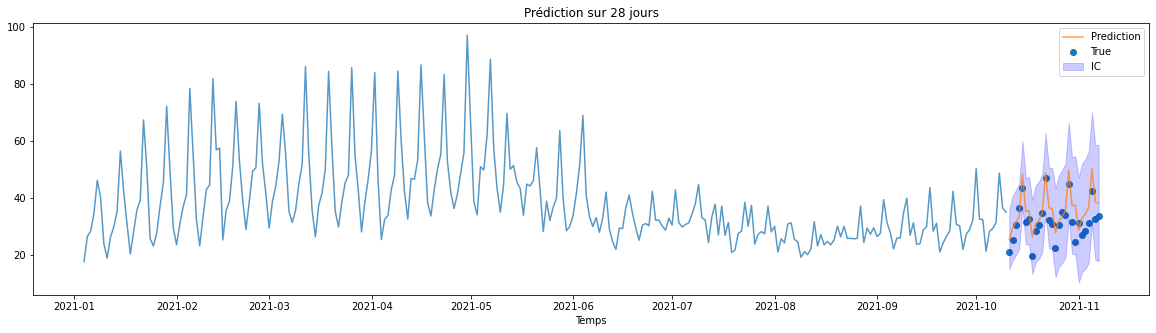

In [77]:
predict(fit1, trainset, testset)

Test RMSE: 4.851


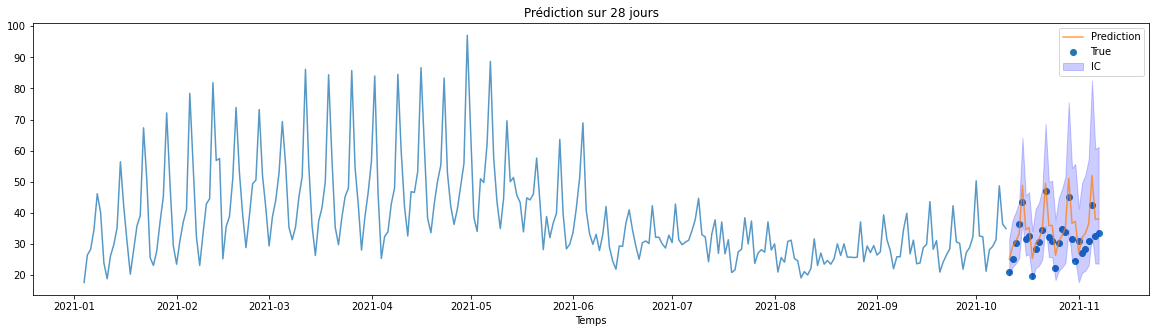

In [78]:
predict(fit2, trainset, testset)

Test RMSE: 5.499


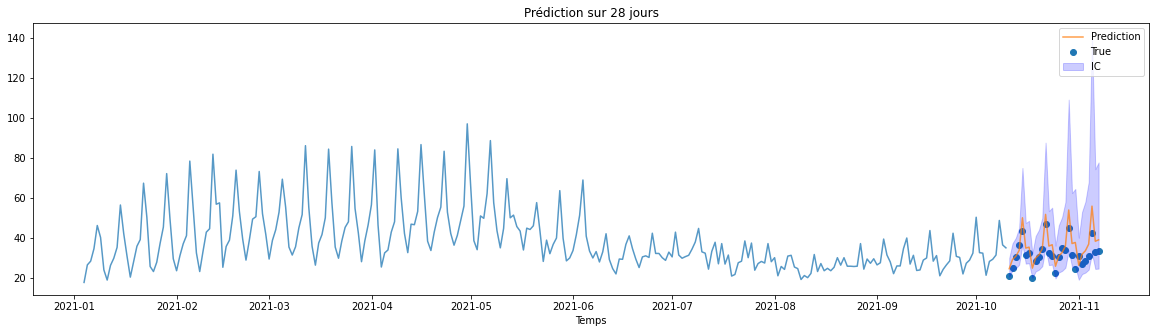

In [79]:
predict(fit3, trainset, testset)